In [309]:
import pandas as pd
import numpy as np

import statsmodels.stats.power as smp
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, KFold
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from itertools import permutations
from scipy.stats import ttest_ind
import arviz as az

import causalpy as cp

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Constants
random_state = 34

## Data Preperation

In [6]:
# Load in claims data by dma, city, state from 2024-01-01 onwards
claims = pd.read_csv('claims_by_dma.csv')
claims

,date,dma_name,city,state,new_persons,returning_persons,claims
0,2024-08-04,Birmingham (Ann and Tusc),Cullman,AL,2,37,46
1,2024-08-05,"Washington, DC (Hagrstwn)",Silver Spring,MD,25,88,140
2,2024-08-09,Paducah-Cape Girard-Harsbg,Jackson,MO,2,27,34
3,2024-08-13,Orlando-Daytona Bch-Melbrn,Lady Lake,FL,4,48,58
4,2024-08-02,Omaha,Council Bluffs,IA,13,76,104
...,...,...,...,...,...,...,...
1731937,2024-04-09,Honolulu,Kamuela,HI,0,3,3
1731938,2024-09-29,Roanoke-Lynchburg,Amherst,VA,1,1,2
1731939,2024-07-13,Los Angeles,Lomita,CA,1,2,3
1731940,2024-06-19,Sioux City,Milford,IA,0,1,1


In [8]:
# Add/Modify columns
claims['city_state'] = claims['city'] + ', ' + claims['state']
claims['date'] = pd.to_datetime(claims['date'])

In [10]:
# Swing State Boolean
claims['swing_state_bool'] = np.where(claims['state'].isin(['AZ', 'NV', 'WI', 'MI', 'PA', 'GA', 'NC']), 1, 0)

swing_state_dmas = claims[claims['swing_state_bool'] == 1].dma_name.unique()
non_swing_dmas = claims[claims['swing_state_bool'] == 0].dma_name.unique()

In [12]:
# Andriod Tier Boolen
tier_1 = ['CA', 'WI', 'KY', 'ME', 'IL', 'ND', 'NV', 'TN', 'HI', 'MI', 'AZ',
          'NJ', 'VT', 'AK', 'ID', 'SC', 'NE', 'MT', 'IN', 'WY', 'MD', 'OR',
          'CT', 'OH', 'IA', 'CO', 'RI', 'VA', 'DE', 'WA']

tier_2 = ['MA', 'GA', 'UT', 'MN', 'SD', 'AL', 'TX', 'KS', 'MS', 'MO', 'NY',
          'FL', 'DC', 'LA', 'NC', 'NM', 'WV', 'PA', 'OK', 'NH', 'AR']

claims['android_tier'] = np.where(claims['state'].isin(tier_1), 1, 2)

# Update tier if dma has cities in both tiers, based on where most claims are from
for dma in claims.dma_name.unique():
    claims_data = claims.copy()[claims['dma_name'] == dma]
    state_list = claims_data.state.unique()
    states_in_teir_1 = len([x for x in state_list if x in tier_1])
    states_in_teir_2 = len([x for x in state_list if x in tier_2])

    if states_in_teir_1 > 0 and states_in_teir_2 > 0:
        dma_top_state = claims_data[['state', 'claims']].groupby('state').sum().sort_values('claims', ascending = False).index[0]
        
        if dma_top_state in tier_1:
            top_state_tier = 1
        else:
            top_state_tier = 2
        claims['android_tier'] = np.where(claims['dma_name'] == dma, top_state_tier, claims['android_tier'])
        
android_teir_1 = claims[claims['android_tier'] == 1].dma_name.unique()
android_teir_2 = claims[claims['android_tier'] == 2].dma_name.unique()

In [13]:
# Group by DMA
claims_dma = claims[['date', 'dma_name', 'new_persons', 'returning_persons', 'claims']].groupby(['date', 'dma_name']).sum().reset_index()

In [14]:
# Create new df with statistics
dma_grouped_df = claims_dma.groupby('dma_name').agg(
    count_date=('date', 'count'),
    avg_new_persons=('new_persons', 'mean'),
    sd_new_persons=('new_persons', 'std'),
    avg_returning_persons=('returning_persons', 'mean'),
    sd_returning_persons=('returning_persons', 'std'), 
    avg_claims = ('claims', 'mean'),
    sd_claims = ('claims', 'std'), 
).reset_index()

dma_grouped_df.head(5)

,dma_name,count_date,avg_new_persons,sd_new_persons,avg_returning_persons,sd_returning_persons,avg_claims,sd_claims
0,Abilene-Sweetwater,276,40.090580,14.185362,313.068841,112.370810,411.913043,148.203986
1,"Albany, GA",276,39.391304,13.779265,289.670290,88.281389,386.804348,119.274922
2,Albany-Schenectady-Troy,276,92.351449,30.027315,504.195652,142.781606,663.112319,190.933701
3,Albuquerque-Santa Fe,276,176.304348,54.383635,910.405797,262.055945,1238.760870,363.760902
4,"Alexandria, LA",276,19.090580,7.546880,143.144928,43.639773,184.188406,57.395667


## Segmentation

In [16]:
# Break out by tier, break out by quantile for each tier
dma_grouped_df['android_tier'] = np.where(dma_grouped_df['dma_name'].isin(android_teir_1), 1, 2)

dma_grouped_df_tier_1 = dma_grouped_df.copy()[dma_grouped_df['android_tier'] == 1].reset_index()
dma_grouped_df_tier_2 = dma_grouped_df.copy()[dma_grouped_df['android_tier'] == 2].reset_index()

dma_grouped_df_tier_1['quantile'] = pd.qcut(dma_grouped_df_tier_1['avg_claims'], q=6, labels=False)
dma_grouped_df_tier_2['quantile'] = pd.qcut(dma_grouped_df_tier_2['avg_claims'], q=6, labels=False)

In [17]:
stratifier = StratifiedKFold(n_splits=6, shuffle=True, random_state=random_state)

# Tier 1 Statify
dma_grouped_df_tier_1['group'] = 0  # Initialize the group column
for i, (_, test_index) in enumerate(stratifier.split(dma_grouped_df_tier_1, dma_grouped_df_tier_1['quantile'])):
    dma_grouped_df_tier_1.loc[test_index, 'group'] = i + 1

# Tier 2 Statify
dma_grouped_df_tier_2['group'] = 0  # Initialize the group column
for i, (_, test_index) in enumerate(stratifier.split(dma_grouped_df_tier_2, dma_grouped_df_tier_2['quantile'])):
    dma_grouped_df_tier_2.loc[test_index, 'group'] = i + 1

# Concat and display
dma_grouped_df = pd.concat([dma_grouped_df_tier_1.set_index('index'), dma_grouped_df_tier_2.set_index('index')]).sort_index()
dma_grouped_df

,dma_name,count_date,avg_new_persons,sd_new_persons,avg_returning_persons,sd_returning_persons,avg_claims,sd_claims,android_tier,quantile,group
index,,,,,,,,,,,
0,Abilene-Sweetwater,276,40.090580,14.185362,313.068841,112.370810,411.913043,148.203986,2,2,5
1,"Albany, GA",276,39.391304,13.779265,289.670290,88.281389,386.804348,119.274922,2,1,3
2,Albany-Schenectady-Troy,276,92.351449,30.027315,504.195652,142.781606,663.112319,190.933701,2,3,3
3,Albuquerque-Santa Fe,276,176.304348,54.383635,910.405797,262.055945,1238.760870,363.760902,2,4,5
4,"Alexandria, LA",276,19.090580,7.546880,143.144928,43.639773,184.188406,57.395667,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...
205,Wilmington,276,74.822464,23.446830,516.311594,153.190852,660.137681,197.110867,2,3,3
206,Yakima-Pasco-Rchlnd-Knnwck,276,54.485507,17.232205,361.746377,110.162331,475.387681,143.976204,1,2,4
207,Youngstown,276,62.420290,22.873029,432.865942,143.239507,563.467391,189.485166,1,2,2


In [18]:
# Segment statistics
grouped_df_stats = dma_grouped_df.groupby('group').agg(
    avg_new_persons=('avg_new_persons', 'sum'),
    sd_new_persons=('sd_new_persons', 'sum'),
    avg_returning_persons=('avg_returning_persons', 'sum'),
    sd_returning_persons=('sd_returning_persons', 'sum'),
    avg_claims =('avg_claims', 'sum'),
    sd_claims=('sd_claims', 'sum')
).reset_index()

grouped_df_stats

,group,avg_new_persons,sd_new_persons,avg_returning_persons,sd_returning_persons,avg_claims,sd_claims
0,1,5812.365942,1738.795959,34919.561594,10169.884301,46938.931159,13760.568865
1,2,3473.807971,1109.781282,22546.902174,6747.355301,29483.355072,8938.892875
2,3,4341.836957,1344.229450,26765.355072,7762.849651,35466.028986,10441.532173
3,4,4820.246377,1480.246757,28677.514493,8487.543982,38129.898551,11388.245231
4,5,5651.909420,1705.864279,31956.681159,9333.962638,42856.822464,12620.898526
5,6,4379.699850,1345.781353,26805.449516,7662.818278,35509.474785,10313.708380


### Treatment and Control Creation

In [19]:
# Create a mapping from the new groupings to mobile segments
youtube_mapping = {group: segment for group, segment in
                  zip([1, 4, 2, 5, 3, 6], (['Treatment 2']* 2) + (['Treatment 1']* 2) + (['Control']*2))}
dma_grouped_df['youtube_segments'] = dma_grouped_df['group'].map(youtube_mapping)

# Create a mapping from the new groupings to mobile segments
app_mapping = {group: segment for group, segment in
                  zip([1, 2, 3, 4, 5, 6], (['Treatment 1']* 3) + (['Control']*3))}
dma_grouped_df['app_segments'] = dma_grouped_df['group'].map(app_mapping)

dma_grouped_df.head()

,dma_name,count_date,avg_new_persons,sd_new_persons,avg_returning_persons,sd_returning_persons,avg_claims,sd_claims,android_tier,quantile,group,youtube_segments,app_segments
index,,,,,,,,,,,,,
0,Abilene-Sweetwater,276,40.090580,14.185362,313.068841,112.370810,411.913043,148.203986,2,2,5,Treatment 1,Control
1,"Albany, GA",276,39.391304,13.779265,289.670290,88.281389,386.804348,119.274922,2,1,3,Control,Treatment 1
2,Albany-Schenectady-Troy,276,92.351449,30.027315,504.195652,142.781606,663.112319,190.933701,2,3,3,Control,Treatment 1
3,Albuquerque-Santa Fe,276,176.304348,54.383635,910.405797,262.055945,1238.760870,363.760902,2,4,5,Treatment 1,Control
4,"Alexandria, LA",276,19.090580,7.546880,143.144928,43.639773,184.188406,57.395667,2,1,1,Treatment 2,Treatment 1


In [20]:
# Check Mobile Segments
app_df_stats = dma_grouped_df.groupby('app_segments').agg(
    avg_new_persons=('avg_new_persons', 'sum'),
    sd_new_persons=('sd_new_persons', 'sum'),
    avg_returning_persons=('avg_returning_persons', 'sum'),
    sd_returning_persons=('sd_returning_persons', 'sum'),
    avg_claims=('avg_claims', 'sum'),
    sd_claims=('sd_claims', 'sum')
).reset_index()

app_df_stats

,app_segments,avg_new_persons,sd_new_persons,avg_returning_persons,sd_returning_persons,avg_claims,sd_claims
0,Control,14851.855647,4531.892389,87439.645168,25484.324898,116496.195799,34322.852137
1,Treatment 1,13628.010870,4192.806691,84231.818841,24680.089253,111888.315217,33140.993914


In [21]:
# Check YouTube Segments
youtube_df_stats = dma_grouped_df.groupby('youtube_segments').agg(
    avg_new_persons=('avg_new_persons', 'sum'),
    sd_new_persons=('sd_new_persons', 'sum'),
    avg_returning_persons=('avg_returning_persons', 'sum'),
    sd_returning_persons=('sd_returning_persons', 'sum'),
    avg_claims=('avg_claims', 'sum'),
    sd_claims=('sd_claims', 'sum')
).reset_index()

youtube_df_stats

,youtube_segments,avg_new_persons,sd_new_persons,avg_returning_persons,sd_returning_persons,avg_claims,sd_claims
0,Control,8721.536807,2690.010803,53570.804588,15425.667929,70975.503770,20755.240553
1,Treatment 1,9125.717391,2815.645562,54503.583333,16081.317938,72340.177536,21559.791401
2,Treatment 2,10632.612319,3219.042716,63597.076087,18657.428283,85068.829710,25148.814096


## Test Set-up Checks

In [32]:
# Build Claims pivots by date
claims_np = claims.groupby(['date', 'dma_name']).sum().reset_index().pivot(index='date', columns='dma_name', values='new_persons')
claims_rp = claims.groupby(['date', 'dma_name']).sum().reset_index().pivot(index='date', columns='dma_name', values='returning_persons')
claims_cl = claims.groupby(['date', 'dma_name']).sum().reset_index().pivot(index='date', columns='dma_name', values='claims')

In [33]:
def filter_and_group_data(claims_df, dma_grouped_df, segment_col, segment_value):
    """
    Filters the claims dataframe by a given segment and groups by date and dma_name, summing the metrics.
    """
    return claims_df[claims_df['dma_name'].isin(dma_grouped_df[dma_grouped_df[segment_col] == segment_value].dma_name)][
        ['date', 'dma_name', 'new_persons', 'returning_persons', 'claims']
    ].groupby(['date', 'dma_name']).sum().reset_index()

def create_pivot(df, value_col):
    """
    Creates a pivot table from the grouped dataframe, pivoting by date and dma_name for the specified value column.
    """
    return df.pivot(index='date', columns='dma_name', values=value_col)

# Create dataframes for mobile segments
app_treatment_1 = filter_and_group_data(claims, dma_grouped_df, 'app_segments', 'Treatment 1')
app_control = filter_and_group_data(claims, dma_grouped_df, 'app_segments', 'Control')

# Create pivots for mobile segments
app_treatment_1_np = create_pivot(app_treatment_1, 'new_persons')
app_control_np = create_pivot(app_control, 'new_persons')

app_treatment_1_rp = create_pivot(app_treatment_1, 'returning_persons')
app_control_rp = create_pivot(app_control, 'returning_persons')

app_treatment_1_cl = create_pivot(app_treatment_1, 'claims')
app_control_cl = create_pivot(app_control, 'claims')

# Create dataframes for YouTube segments
youtube_treatment_2 = filter_and_group_data(claims, dma_grouped_df, 'youtube_segments', 'Treatment 2')
youtube_treatment_1 = filter_and_group_data(claims, dma_grouped_df, 'youtube_segments', 'Treatment 1')
youtube_control = filter_and_group_data(claims, dma_grouped_df, 'youtube_segments', 'Control')

# Create pivots for YouTube segments
youtube_treatment_2_np = create_pivot(youtube_treatment_2, 'new_persons')
youtube_treatment_1_np = create_pivot(youtube_treatment_1, 'new_persons')
youtube_control_np = create_pivot(youtube_control, 'new_persons')

youtube_treatment_2_rp = create_pivot(youtube_treatment_2, 'returning_persons')
youtube_treatment_1_rp = create_pivot(youtube_treatment_1, 'returning_persons')
youtube_control_rp = create_pivot(youtube_control, 'returning_persons')

youtube_treatment_2_cl = create_pivot(youtube_treatment_2, 'claims')
youtube_treatment_1_cl = create_pivot(youtube_treatment_1, 'claims')
youtube_control_cl = create_pivot(youtube_control, 'claims')

In [34]:
# Create total time series for each segment, new persons
claims_np_sum = claims_np.sum(axis = 1)
app_treatment_1_np_sum = app_treatment_1_np.sum(axis=1)
app_control_np_sum = app_control_np.sum(axis=1)

# returning persons
claims_rp_sum = claims_rp.sum(axis = 1)
app_treatment_1_rp_sum = app_treatment_1_rp.sum(axis=1)
app_control_rp_sum = app_control_rp.sum(axis=1)

# total claims
claims_cl_sum = claims_cl.sum(axis = 1)
app_treatment_1_cl_sum = app_treatment_1_cl.sum(axis=1)
app_control_cl_sum = app_control_cl.sum(axis=1)

# Create total time series for each segment, new persons
claims_np_sum = claims_np.sum(axis = 1)
youtube_treatment_2_np_sum = youtube_treatment_2_np.sum(axis = 1)
youtube_treatment_1_np_sum = youtube_treatment_1_np.sum(axis=1)
youtube_control_np_sum = youtube_control_np.sum(axis=1)

# returning persons
claims_rp_sum = claims_rp.sum(axis = 1)
youtube_treatment_2_rp_sum = youtube_treatment_2_rp.sum(axis = 1)
youtube_treatment_1_rp_sum = youtube_treatment_1_rp.sum(axis=1)
youtube_control_rp_sum = youtube_control_rp.sum(axis=1)

# total claims
claims_cl_sum = claims_cl.sum(axis = 1)
youtube_treatment_2_cl_sum = youtube_treatment_2_cl.sum(axis = 1)
youtube_treatment_1_cl_sum = youtube_treatment_1_cl.sum(axis=1)
youtube_control_cl_sum = youtube_control_cl.sum(axis=1)

### Tier Distribution

In [36]:
tier_1_dmas = dma_grouped_df[dma_grouped_df['android_tier'] == 1]
tier_1_dmas[['app_segments', 'avg_new_persons', 'avg_returning_persons', 'avg_claims']].groupby('app_segments').sum()

,avg_new_persons,avg_returning_persons,avg_claims
app_segments,,,
Control,6304.659995,37769.181400,49974.366089
Treatment 1,6133.851449,37704.876812,49991.717391


In [37]:
tier_2_dmas = dma_grouped_df[dma_grouped_df['android_tier'] == 2]
tier_2_dmas[['app_segments', 'avg_new_persons', 'avg_returning_persons', 'avg_claims']].groupby('app_segments').sum()

,avg_new_persons,avg_returning_persons,avg_claims
app_segments,,,
Control,8547.195652,49670.463768,66521.829710
Treatment 1,7494.159420,46526.942029,61896.597826


### Swing State Distribution

In [52]:
swing_state_dmas

array(['Atlanta', 'Las Vegas', 'Greensboro-H.Point-W.Salem',
       'Phoenix (Prescott)', 'Raleigh-Durham (Fayetvlle)',
       'Yuma-El Centro', 'Charlotte', 'Pittsburgh', 'Wausau-Rhinelander',
       'Lansing', 'Flint-Saginaw-Bay City', 'Grand Rapids-Kalmzoo-B.Crk',
       'Milwaukee', 'Reno', 'Green Bay-Appleton',
       'Greenville-N.Bern-Washngtn', 'Detroit',
       'Harrisburg-Lncstr-Leb-York', 'Tucson (Sierra Vista)', 'Alpena',
       'Philadelphia', 'Wilmington', 'Wilkes Barre-Scranton-Hztn',
       'Albany, GA', 'Macon', 'Traverse City-Cadillac',
       'Johnstown-Altoona-St Colge', 'South Bend-Elkhart',
       'Tallahassee-Thomasville', 'Youngstown', 'Jacksonville', 'Madison',
       'Augusta-Aiken', 'Greenvll-Spart-Ashevll-And', 'Erie',
       'Minneapolis-St. Paul', 'Norfolk-Portsmth-Newpt Nws',
       'Chattanooga', 'La Crosse-Eau Claire', 'New York', 'Savannah',
       'Myrtle Beach-Florence', 'Salt Lake City', 'Duluth-Superior',
       'Columbus, GA (Opelika, AL)', 'Buffa

In [58]:
swing_dmas = dma_grouped_df[dma_grouped_df['dma_name'].isin(swing_state_dmas)]

swing_dmas[['app_segments', 'avg_new_persons', 'avg_returning_persons', 'avg_claims']].groupby('app_segments').sum()

,avg_new_persons,avg_returning_persons,avg_claims
app_segments,,,
Control,5032.144928,28622.434783,38400.362319
Treatment 1,4289.873188,27313.800725,36097.155797


In [60]:
swing_dmas[['youtube_segments', 'avg_new_persons', 'avg_returning_persons', 'avg_claims']].groupby('youtube_segments').sum()

,avg_new_persons,avg_returning_persons,avg_claims
youtube_segments,,,
Control,2552.003623,16710.695652,22043.884058
Treatment 1,3340.369565,18258.373188,24570.402174
Treatment 2,3429.644928,20967.166667,27883.231884


### National Representativeness

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/var/folders/n4/96b1c6px5kz8sdgcmpq0wy7h0000gp/T/ipykernel_93444/344754082.py:64: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


R² NP (Scaled Treatment 1): 0.9988
R² NP (Scaled Control): 0.9990
R² CL (Scaled Treatment 1): 0.9995
R² CL (Scaled Control): 0.9995
R² RP (Scaled Treatment 1): 0.9995
R² RP (Scaled Control): 0.9996


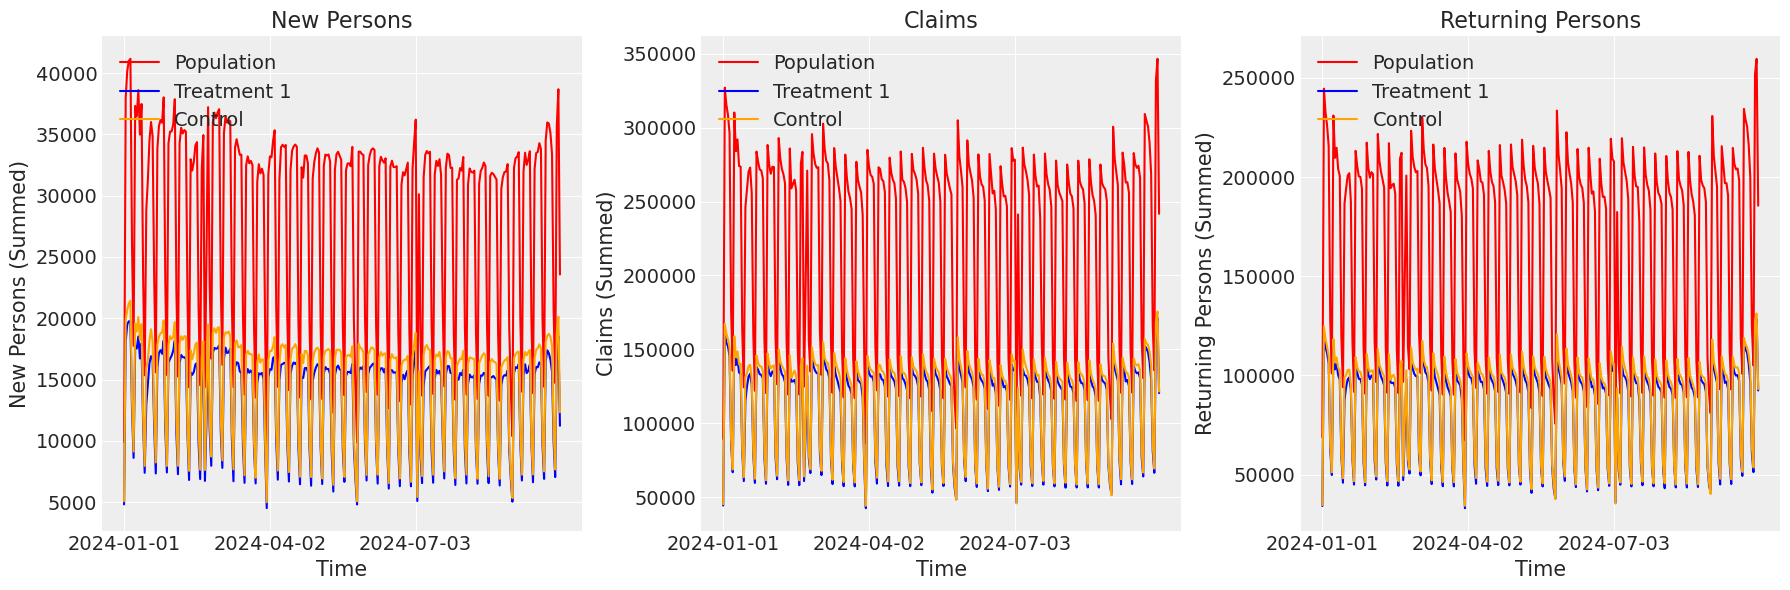

In [63]:
# App

# Set up a 1x3 subplot figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# Choose a reduced number of ticks for the x-axis
ticks = claims_np_sum.index[::len(claims_np_sum)//3]  # Take 3 evenly spaced dates

# Plot for New Persons (NP)
axes[0].plot(claims_np_sum, label='Population', color='red')
axes[0].plot(app_treatment_1_np_sum, label='Treatment 1', color='blue')
axes[0].plot(app_control_np_sum, label='Control', color='orange')
axes[0].set_title('New Persons')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('New Persons (Summed)')
axes[0].legend(loc='upper left')  # Set legend position to top-left
axes[0].set_xticks(ticks)
axes[0].set_xticklabels(ticks.strftime('%Y-%m-%d'))  # Format date labels

# Calculate and print R² values for NP
treatment_1_r2_np = r2_score((app_treatment_1_np_sum * (claims_np_sum.sum() / app_treatment_1_np_sum.sum())), claims_np_sum)
control_r2_np = r2_score((app_control_np_sum * (claims_np_sum.sum() / app_control_np_sum.sum())), claims_np_sum)

print(f"R² NP (Scaled Treatment 1): {treatment_1_r2_np:.4f}")
print(f"R² NP (Scaled Control): {control_r2_np:.4f}")

# Plot for Claims (CL)
axes[1].plot(claims_cl_sum, label='Population', color='red')
axes[1].plot(app_treatment_1_cl_sum, label='Treatment 1', color='blue')
axes[1].plot(app_control_cl_sum, label='Control', color='orange')
axes[1].set_title('Claims')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Claims (Summed)')
axes[1].legend(loc='upper left')  # Set legend position to top-left
axes[1].set_xticks(ticks)
axes[1].set_xticklabels(ticks.strftime('%Y-%m-%d'))

# Calculate and print R² values for CL
treatment_1_r2_cl = r2_score((app_treatment_1_cl_sum * (claims_cl_sum.sum() / app_treatment_1_cl_sum.sum())), claims_cl_sum)
control_r2_cl = r2_score((app_control_cl_sum * (claims_cl_sum.sum() / app_control_cl_sum.sum())), claims_cl_sum)

print(f"R² CL (Scaled Treatment 1): {treatment_1_r2_cl:.4f}")
print(f"R² CL (Scaled Control): {control_r2_cl:.4f}")

# Plot for Returning Persons (RP)
axes[2].plot(claims_rp_sum, label='Population', color='red')
axes[2].plot(app_treatment_1_rp_sum, label='Treatment 1', color='blue')
axes[2].plot(app_control_rp_sum, label='Control', color='orange')
axes[2].set_title('Returning Persons')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Returning Persons (Summed)')
axes[2].legend(loc='upper left')  # Set legend position to top-left
axes[2].set_xticks(ticks)
axes[2].set_xticklabels(ticks.strftime('%Y-%m-%d'))

# Calculate and print R² values for RP
treatment_1_r2_rp = r2_score((app_treatment_1_rp_sum * (claims_rp_sum.sum() / app_treatment_1_rp_sum.sum())), claims_rp_sum)
control_r2_rp = r2_score((app_control_rp_sum * (claims_rp_sum.sum() / app_control_rp_sum.sum())), claims_rp_sum)

print(f"R² RP (Scaled Treatment 1): {treatment_1_r2_rp:.4f}")
print(f"R² RP (Scaled Control): {control_r2_rp:.4f}")

# Adjust layout and display the combined plot
plt.tight_layout()
plt.show()


R² NP (Scaled Treatment 2): 0.9981
R² NP (Scaled Treatment 1): 0.9980
R² NP (Scaled Control): 0.9975
R² CL (Scaled Treatment 2): 0.9990
R² CL (Scaled Treatment 1): 0.9991
R² CL (Scaled Control): 0.9985
R² RP (Scaled Treatment 2): 0.9990
R² RP (Scaled Treatment 1): 0.9991
R² RP (Scaled Control): 0.9984


/var/folders/n4/96b1c6px5kz8sdgcmpq0wy7h0000gp/T/ipykernel_93444/2631317496.py:73: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


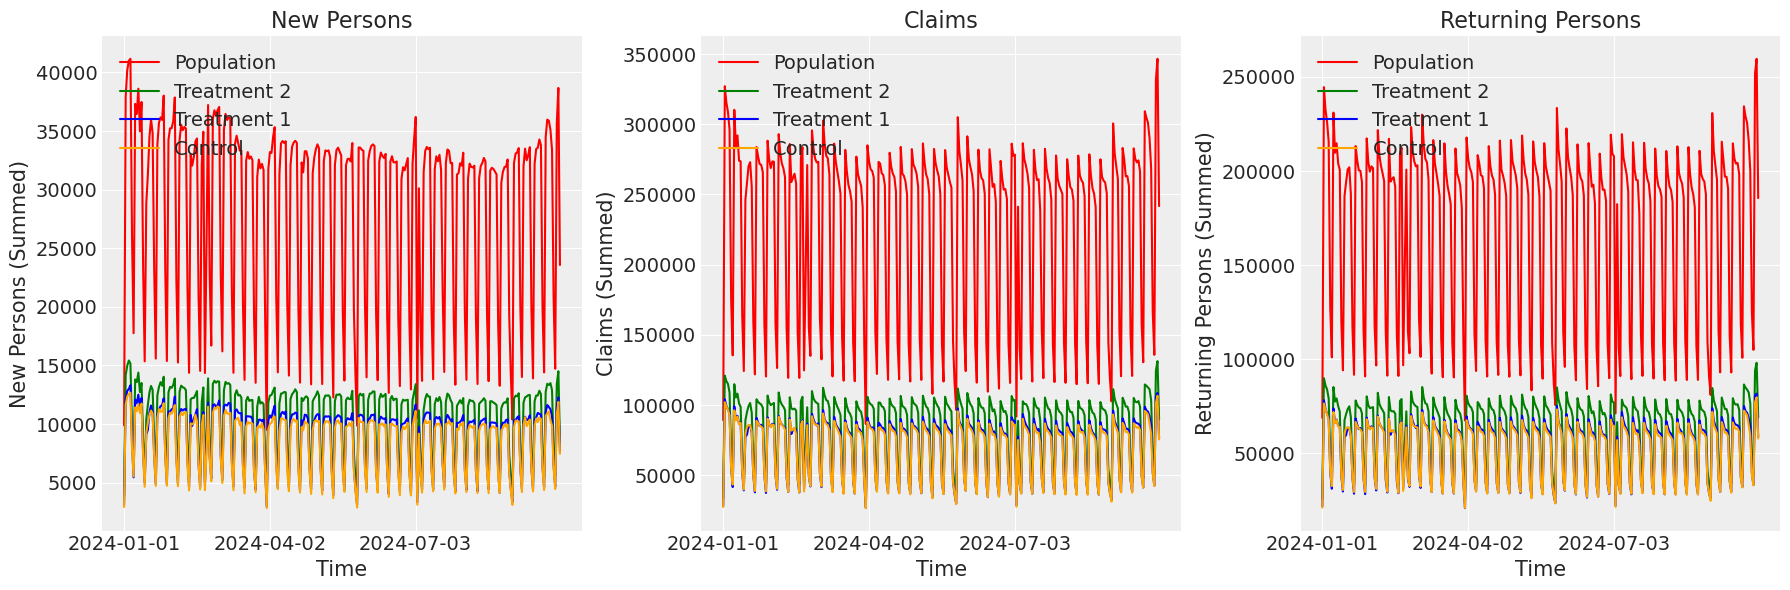

In [64]:
# YouTube

# Set up a 1x3 subplot figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# Choose a reduced number of ticks for the x-axis
ticks = claims_np_sum.index[::len(claims_np_sum)//3]  # Take 3 evenly spaced dates

# Plot for New Persons (NP)
axes[0].plot(claims_np_sum, label='Population', color='red')
axes[0].plot(youtube_treatment_2_np_sum, label='Treatment 2', color='green')
axes[0].plot(youtube_treatment_1_np_sum, label='Treatment 1', color='blue')
axes[0].plot(youtube_control_np_sum, label='Control', color='orange')
axes[0].set_title('New Persons')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('New Persons (Summed)')
axes[0].legend(loc='upper left')  # Set legend position to top-left
axes[0].set_xticks(ticks)
axes[0].set_xticklabels(ticks.strftime('%Y-%m-%d'))  # Format date labels

# Calculate and print R² values for NP
treatment_2_r2_np = r2_score((youtube_treatment_2_np_sum * (claims_np_sum.sum() / youtube_treatment_2_np_sum.sum())), claims_np_sum)
treatment_1_r2_np = r2_score((youtube_treatment_1_np_sum * (claims_np_sum.sum() / youtube_treatment_1_np_sum.sum())), claims_np_sum)
control_r2_np = r2_score((youtube_control_np_sum * (claims_np_sum.sum() / youtube_control_np_sum.sum())), claims_np_sum)

print(f"R² NP (Scaled Treatment 2): {treatment_2_r2_np:.4f}")
print(f"R² NP (Scaled Treatment 1): {treatment_1_r2_np:.4f}")
print(f"R² NP (Scaled Control): {control_r2_np:.4f}")

# Plot for Claims (CL)
axes[1].plot(claims_cl_sum, label='Population', color='red')
axes[1].plot(youtube_treatment_2_cl_sum, label='Treatment 2', color='green')
axes[1].plot(youtube_treatment_1_cl_sum, label='Treatment 1', color='blue')
axes[1].plot(youtube_control_cl_sum, label='Control', color='orange')
axes[1].set_title('Claims')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Claims (Summed)')
axes[1].legend(loc='upper left')  # Set legend position to top-left
axes[1].set_xticks(ticks)
axes[1].set_xticklabels(ticks.strftime('%Y-%m-%d'))

# Calculate and print R² values for CL
treatment_2_r2_cl = r2_score((youtube_treatment_2_cl_sum * (claims_cl_sum.sum() / youtube_treatment_2_cl_sum.sum())), claims_cl_sum)
treatment_1_r2_cl = r2_score((youtube_treatment_1_cl_sum * (claims_cl_sum.sum() / youtube_treatment_1_cl_sum.sum())), claims_cl_sum)
control_r2_cl = r2_score((youtube_control_cl_sum * (claims_cl_sum.sum() / youtube_control_cl_sum.sum())), claims_cl_sum)

print(f"R² CL (Scaled Treatment 2): {treatment_2_r2_cl:.4f}")
print(f"R² CL (Scaled Treatment 1): {treatment_1_r2_cl:.4f}")
print(f"R² CL (Scaled Control): {control_r2_cl:.4f}")

# Plot for Returning Persons (RP)
axes[2].plot(claims_rp_sum, label='Population', color='red')
axes[2].plot(youtube_treatment_2_rp_sum, label='Treatment 2', color='green')
axes[2].plot(youtube_treatment_1_rp_sum, label='Treatment 1', color='blue')
axes[2].plot(youtube_control_rp_sum, label='Control', color='orange')
axes[2].set_title('Returning Persons')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Returning Persons (Summed)')
axes[2].legend(loc='upper left')  # Set legend position to top-left
axes[2].set_xticks(ticks)
axes[2].set_xticklabels(ticks.strftime('%Y-%m-%d'))

# Calculate and print R² values for RP
treatment_2_r2_rp = r2_score((youtube_treatment_2_rp_sum * (claims_rp_sum.sum() / youtube_treatment_2_rp_sum.sum())), claims_rp_sum)
treatment_1_r2_rp = r2_score((youtube_treatment_1_rp_sum * (claims_rp_sum.sum() / youtube_treatment_1_rp_sum.sum())), claims_rp_sum)
control_r2_rp = r2_score((youtube_control_rp_sum * (claims_rp_sum.sum() / youtube_control_rp_sum.sum())), claims_rp_sum)

print(f"R² RP (Scaled Treatment 2): {treatment_2_r2_rp:.4f}")
print(f"R² RP (Scaled Treatment 1): {treatment_1_r2_rp:.4f}")
print(f"R² RP (Scaled Control): {control_r2_rp:.4f}")

# Adjust layout and display the combined plot
plt.tight_layout()
plt.show()


### Outputs

In [68]:
 # Create DMA names by geo df
dma_groupings_final = dma_grouped_df.pivot_table(index=dma_grouped_df.groupby('group').cumcount(), columns='group', values='dma_name', aggfunc=lambda x: x)
dma_groupings_final = dma_groupings_final.reset_index(drop=True)
dma_groupings_final.to_csv('dma_groupings_final.csv')

# Create DMA names by geo mapping doc
dma_grouped_df[['dma_name', 'group', 'app_segments', 'youtube_segments']].sort_values('dma_name').reset_index().drop('index', axis = 1).to_csv('dma_mapping.csv')

In [70]:
dma_grouped_df

,dma_name,count_date,avg_new_persons,sd_new_persons,avg_returning_persons,sd_returning_persons,avg_claims,sd_claims,android_tier,quantile,group,youtube_segments,app_segments
index,,,,,,,,,,,,,
0,Abilene-Sweetwater,276,40.090580,14.185362,313.068841,112.370810,411.913043,148.203986,2,2,5,Treatment 1,Control
1,"Albany, GA",276,39.391304,13.779265,289.670290,88.281389,386.804348,119.274922,2,1,3,Control,Treatment 1
2,Albany-Schenectady-Troy,276,92.351449,30.027315,504.195652,142.781606,663.112319,190.933701,2,3,3,Control,Treatment 1
3,Albuquerque-Santa Fe,276,176.304348,54.383635,910.405797,262.055945,1238.760870,363.760902,2,4,5,Treatment 1,Control
4,"Alexandria, LA",276,19.090580,7.546880,143.144928,43.639773,184.188406,57.395667,2,1,1,Treatment 2,Treatment 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,Wilmington,276,74.822464,23.446830,516.311594,153.190852,660.137681,197.110867,2,3,3,Control,Treatment 1
206,Yakima-Pasco-Rchlnd-Knnwck,276,54.485507,17.232205,361.746377,110.162331,475.387681,143.976204,1,2,4,Treatment 2,Control
207,Youngstown,276,62.420290,22.873029,432.865942,143.239507,563.467391,189.485166,1,2,2,Treatment 1,Treatment 1
